In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.linalg import dft
import lib
from importlib import reload

In [50]:
nside = 64
reload(lib)
P = lib.generate_pointing(nside)
nsamp = P.shape[0]
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)
    
print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

Total samples: 8192
Total time: 819.2


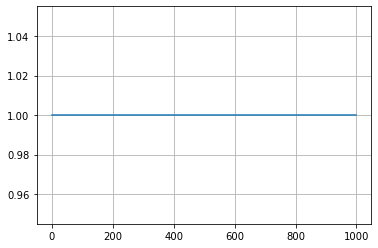

In [51]:
pix_size = 10 #arcmin
ell = np.arange(0, 1000)
Dl = np.ones_like(ell)
plt.plot(ell, Dl)
plt.grid()

/scratch/yuyang/destripe/lib.py:8: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1))
/scratch/yuyang/destripe/lib.py:23: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Cl2d))


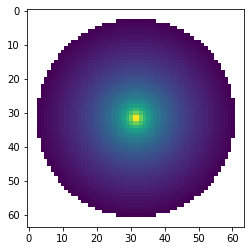

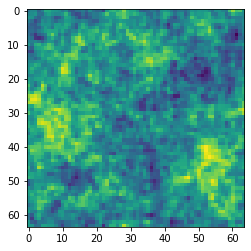

In [52]:
reload(lib)
m = lib.generate_map(Dl, nside, pix_size)
plt.imshow(m)

In [54]:
reload(lib)
M, M_c, dft2, dft2_inv = lib.generate_mask(m, pix_size, ell_cutoff = 300)

In [63]:
fft_map = (dft2 @ m.flatten()).reshape(nside, nside)

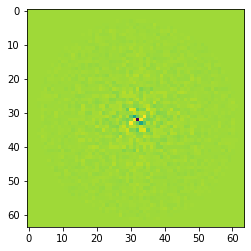

In [77]:
plt.imshow(np.fft.fftshift(fft_map).real)

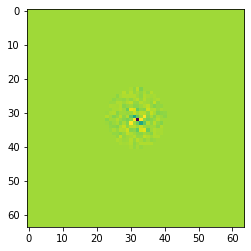

In [78]:
plt.imshow(np.fft.fftshift(M @ fft_map).real)

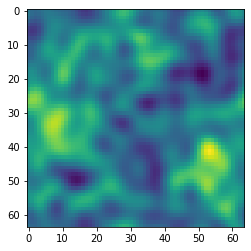

In [69]:
lf_map = np.fft.ifft2(M @ fft_map)
plt.imshow(lf_map.real)

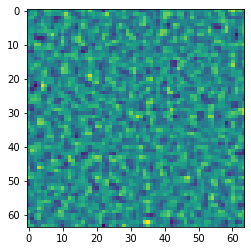

In [70]:
hf_map = np.fft.ifft2(M_c @ fft_map)
plt.imshow(hf_map.real)

In [76]:
(lf_map + hf_map - m).max() 
#yay

(7.427392034742297e-14-2.806088694740083e-14j)

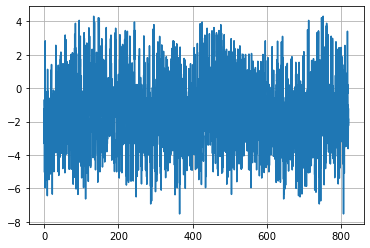

In [81]:
signal = P@m.flatten()
plt.plot(times, signal)
plt.grid()

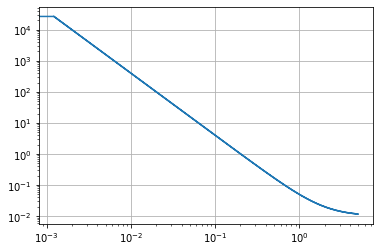

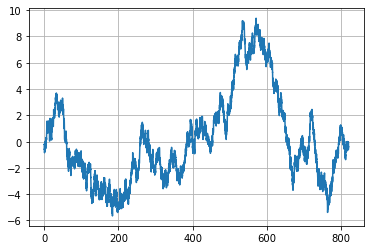

In [87]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=2, alpha=2, sigma=1e-1)
plt.plot(times, noise)
plt.grid()

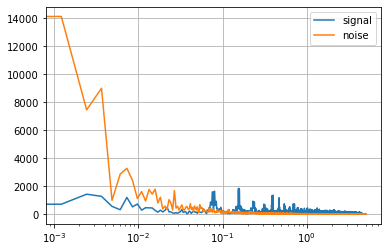

In [88]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_signal = np.fft.rfft(signal)
fft_noise = np.fft.rfft(noise)
plt.plot(freqs, np.abs(fft_signal), label='signal')
plt.plot(freqs, np.abs(fft_noise), label='noise')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.ylim([0, 1])
plt.grid()

In [89]:
y = signal + noise # + n

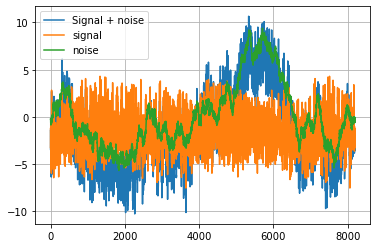

In [90]:
plt.plot(y, label='Signal + noise')
plt.plot(signal, label='signal')
plt.plot(noise, label='noise')
plt.legend()
plt.grid()

In [180]:
#Baselines matrix F
reload(lib)
baseline_length = 10 #seconds
F = generate_baselines(baseline_length, nsamp, rate)

In [181]:
# destriping
Z = np.eye(nsamp) - P @ np.linalg.inv(P.T @ P) @ P.T

#Ax = b
A = F.T @ Z @ F 
b = F.T @ Z @ y

print(A.shape, np.linalg.matrix_rank(A))

# Solution for amplitudes
a = np.linalg.solve(A, b)

(81, 81) 81


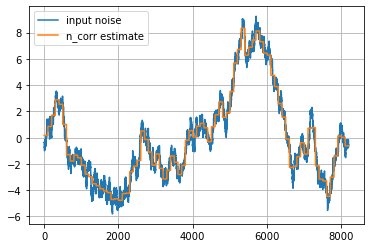

In [182]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F @ a - np.mean(F@a), label='n_corr estimate')
plt.grid()
plt.legend()

In [208]:
m_solver = np.linalg.inv(P.T @ P) @ P.T

m_destripe = m_solver @ (y - F @ a) #Destriping solution
# m_bin = m_solver @ y #Binned map solution

#remove monopole
m_destripe -= np.mean(m_destripe)
# m_bin -= np.mean(m_bin)

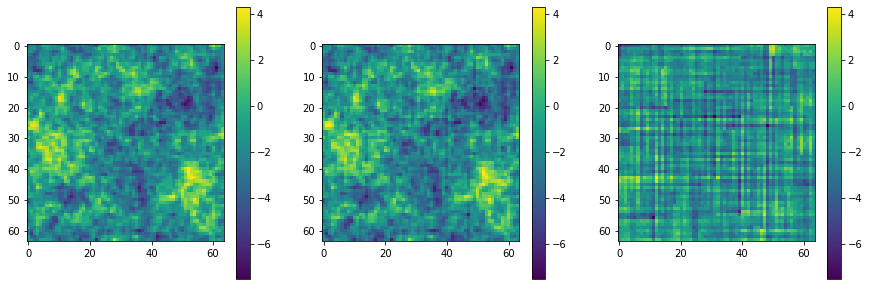

Input map std: 1.8535062022726256
Solved map std: 1.882092561546433


In [214]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(m)
output_map = axes[1].imshow(m_destripe.reshape(nside, nside))
diff_map = axes[2].imshow(m - m_destripe.reshape(nside, nside))

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(input_map, ax=axes[1])
fig.colorbar(input_map, ax=axes[2])

plt.show()
print(f'Input map std: {np.std(m)}')
print(f'Solved map std: {np.std(m_destripe)}')